In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dir_path = "C:/Users/Chong/Documents/Work Directory(2020)/(Data)Drug Screen Location Data/DH-A Location Data New.csv"

In [3]:
plate_a = np.array([])

### Location Data Preprocessing

In [4]:
#Preprocessing
def read_file(dir_path):
    location_data = pd.read_csv(dir_path)           #read file
    location_data.columns = ['location']            #rename column name for ease of processing
    location_data = pd.DataFrame(location_data['location'].str.split(';', expand = True)) #separate the location data from string into respective x, y, and z values
    location_data = location_data.astype(float)     #convert all to float
    location_data.columns = ['x','y','z']           #name columns
    location_data['distance'] = (location_data['x']**2+location_data['y']**2)**(0.5)  #Find Distance from the center of the plate to each well
    return (location_data)

In [5]:
location_data = read_file(dir_path)
location_data.head

<bound method NDFrame.head of           x       y        z   distance
0    47.118 -29.905  8067.20  55.806944
1    47.768 -29.905  8061.56  56.356817
2    48.420 -29.903  8058.96  56.909453
3    48.727 -30.560  8072.82  57.517251
4    48.078 -30.560  8073.54  56.968480
..      ...     ...      ...        ...
275  47.032  29.841  8028.40  55.700039
276  47.363  30.491  8028.84  56.328988
277  48.662  30.492  8027.10  57.426059
278  49.655  31.131  8026.88  58.606810
279  48.355  31.131  8005.18  57.509523

[280 rows x 4 columns]>

### Finding Minimum Distance between each well

In [6]:
def find_min_dist(location_data):
    c_point = location_data['distance'][0]
    distances = []
    x_sep = 3.
    for index, row in location_data.iterrows():
        if (abs(row['distance']-c_point)> x_sep):
            distances.append(abs(row['distance']-c_point))
        c_point = row['distance']    
    return(min(distances))

In [7]:
distance = find_min_dist(location_data)
print(distance)

3.320224755446617


### Generating Clusters

In [8]:
def find_clusters(location_data, distance):
    c_point = location_data['distance'][0]
    c_cluster = []
    cluster = []
    x_sep = distance
    for index, row in location_data.iterrows():
        if (abs(row['distance']-c_point)< x_sep):
            c_cluster.append(index)
        else:
            cluster.append(c_cluster)
            c_cluster = [index]
            #print('index', index, 'val',abs(row['distance']-c_point))
        c_point = row['distance']
    cluster.append(c_cluster)
    cluster = np.array(cluster)
    return(cluster)

In [9]:
cluster = find_clusters(location_data, distance)

### Checking Index for each colony

In [10]:
def return_elements(cluster, num_elem):
    ds_index = [i[:num_elem] for i in cluster]
    return (ds_index)

In [11]:
num_elem = 1
ind = return_elements(cluster, num_elem)
print(ind)

[[0], [10], [20], [40], [50], [60], [69], [72], [76], [85], [95], [101], [105], [115], [117], [118], [124], [128], [133], [136], [148], [160], [170], [180], [198], [206], [222], [232], [240], [250], [270]]


### Generate Drug Labels

In [12]:
drug_lib_path = "C:/Users/Chong/Documents/Work Directory(2020)/(Data)Drug Screen Location Data/Plate Layout PS.xlsx"  #Path with drug list with dead plates
drug_library = pd.ExcelFile(drug_lib_path) 
A_list = pd.read_excel(drug_library, 'A')

In [13]:
def drug_list_generation(plate_list):
    col_names = [i for i in range(len(plate_list.columns))]
    row_names = plate_list.index.values
    row_names = list(row_names)
    drug_list = []
    for i in row_names:
        v = i/2
        if v%2 !=0:
            for j in range(len(col_names)):
                if plate_list.loc[i,j] != 'dead':
                    drug_list.append(plate_list.loc[i,j])
        else:
            for k in range(len(col_names)-1, -1, -1):
                if plate_list.loc[i,k] != 'dead':
                    drug_list.append(plate_list.loc[i,k])
    return (drug_list)

In [14]:
def drug_name_processing(drug_library, plate_name):
    plate = pd.read_excel(drug_library, plate_name)
    z = [2*(i+1) for i in range(int(len(plate.index)/2))]
    plate = plate.iloc[z,:]
    plate = plate.dropna(axis=1, thresh = 4)
    plate.fillna("dead", inplace = True)
    plate.columns = [i for i in range(len(plate.columns))]
    return (plate)

In [15]:
C_list = drug_name_processing(drug_library, 'C')
C_list

,0,1,2,3,4,5,6,7,8,9,10
2,mTeSR1,dead,LY294002,CHIR-99021 (CT99021),PIK-93,dead,dead,Myricitrin,MK-0752,dead,GW788388
4,mTeSR1,Y-27632 2HCl,dead,TG100-115,Fludarabine,"Sonidegib (Erismodegib, NVP-LDE225)","Idelalisib (CAL-101, GS-1101)",Indirubin,dead,Dibenzazepine (YO-01027),dead
6,BMP4(DMSO),Enzastaurin (LY317615),AG-490 (Tyrphostin B42),Ruxolitinib (INCB018424),"Voxtalisib (SAR245409, XL765) Analogue",dead,PIK-294,Quercetin,AS-252424,LY411575,3-Methyladenine (3-MA)
8,BMP4(DMSO),dead,S3I-201,Resveratrol,LY2811376,dead,Galunisertib (LY2157299),Curcumol,AS-604850,SB415286,PF-5274857
10,dead,SB431542,TGX-221,Thiazovivin,Fasudil (HA-1077) HCl,SB505124,dead,Daphnetin,CAY10505,dead,dead
12,dead,dead,XAV-939,dead,H 89 2HCl,PIK-293,Artesunate,Mifepristone,dead,dead,"Tofacitinib (CP-690550,Tasocitinib)"
14,dead,SB216763,dead,GSK429286A,dead,dead,Cryptotanshinone,dead,dead,CHIR-98014,Sotrastaurin
16,dead,Vismodegib (GDC-0449),Avagacestat (BMS-708163),SB525334,Semagacestat (LY450139),DAPT (GSI-IX),Hesperetin,dead,dead,dead,dead


In [16]:
C_drug_list = drug_list_generation(C_list)

In [17]:
C_drug_list 

['mTeSR1',
 'LY294002',
 'CHIR-99021 (CT99021)',
 'PIK-93',
 'Myricitrin',
 'MK-0752',
 'GW788388',
 'Dibenzazepine (YO-01027)',
 'Indirubin',
 'Idelalisib (CAL-101, GS-1101)',
 'Sonidegib (Erismodegib, NVP-LDE225)',
 'Fludarabine',
 'TG100-115',
 'Y-27632 2HCl',
 'mTeSR1',
 'BMP4(DMSO)',
 'Enzastaurin (LY317615)',
 'AG-490 (Tyrphostin B42)',
 'Ruxolitinib (INCB018424)',
 'Voxtalisib (SAR245409, XL765) Analogue',
 'PIK-294',
 'Quercetin',
 'AS-252424',
 'LY411575',
 '3-Methyladenine (3-MA)',
 'PF-5274857',
 'SB415286',
 'AS-604850',
 'Curcumol',
 'Galunisertib (LY2157299)',
 'LY2811376',
 'Resveratrol',
 'S3I-201',
 'BMP4(DMSO)',
 'SB431542',
 'TGX-221',
 'Thiazovivin',
 'Fasudil (HA-1077) HCl',
 'SB505124',
 'Daphnetin',
 'CAY10505',
 'Tofacitinib (CP-690550,Tasocitinib)',
 'Mifepristone',
 'Artesunate',
 'PIK-293',
 'H 89 2HCl',
 'XAV-939',
 'SB216763',
 'GSK429286A',
 'Cryptotanshinone',
 'CHIR-98014',
 'Sotrastaurin',
 'Hesperetin',
 'DAPT (GSI-IX)',
 'Semagacestat (LY450139)',
 'S

In [18]:
import pims

In [19]:
from nd2reader import ND2Reader

In [20]:
dir_path = 'C:/Users/Chong/Documents/Work Directory(2020)/(Data)Drug Screen Location Data/ND2Test/(DS Main) Plate No DH-A (Max).nd2'

In [21]:
images = ND2Reader(dir_path)
images.iter_axes = 'v'

In [22]:
images.sizes

{'x': 1024, 'y': 1024, 'c': 5, 't': 1, 'v': 280}

In [23]:
images.iter_axes = 'cv'
len(images)

1400

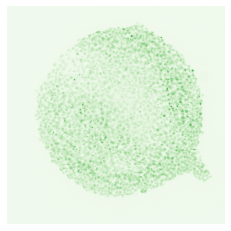

In [27]:
plt.imshow(images[12], cmap = 'Reds')
plt.imshow(images[11], cmap = 'Greens')
plt.axis('off')
plt.show()

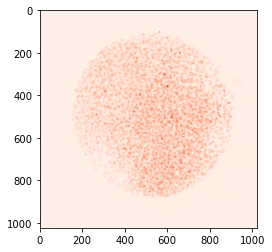

In [25]:
plt.imshow(images[12], cmap = 'Reds')